In [1]:
# Let's grab the famous MNIST dataset

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

In [2]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
# Data structure for Scikit-Learn datasets include:
# DESCR key - description
# data - one row per instance and column per feature
# target key - labels

X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


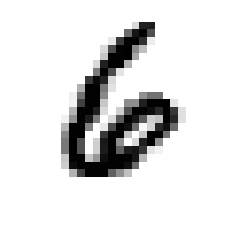

In [4]:
# each image is a 28 * 28 photo, hence each feature is a flattened array of the photo 
# with the data being the intensity (white -> black)

import matplotlib as mpl
import matplotlib.pyplot as plt

first_instance = X[13]
unflattened_instance = first_instance.reshape(28,28)

plt.imshow(unflattened_instance, cmap='binary')
plt.axis('off')
plt.show()

In [5]:
y[0]

'5'

In [6]:
import numpy as np
y = y.astype(np.uint8)
y[0]

5

In [7]:
# Let's split our sets before we get going
X_train, y_train, X_test, y_test = X[:6000], y[:6000], X[6000:], y[6000:]

In [8]:
# Let's start with 1 digit, let's say 6.
# And because I want to test how well it does, I am going to grab 9 too ;)

y_train_6 = (y_train == 6)
y_train_9 = (y_train == 9)
y_test_6 = (y_test == 6)
y_test_9 = (y_test == 9)

In [9]:
# Stochastic Gradient Decent or SGD is a good place to start. This works by creating an error function,
# And then moving down the error curve by tweaking weights in order to arrive at a function that 
# minimizes error and maximizes correctness.

from sklearn.linear_model import SGDClassifier

sgd_6 = SGDClassifier(random_state=23)

In [10]:
sgd_6.fit(X_train, y_train_6)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=23, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [11]:
sgd_6.predict([X[13]])

array([ True])

In [12]:
# Let's try against a 9
sgd_6.predict([X[4]])

array([False])

In [13]:
# Let's Evaluate the model
from sklearn.model_selection import cross_val_score

In [14]:
cross_val_score(sgd_6, X_train, y_train_6, cv=3, scoring='accuracy')

array([0.9685, 0.978 , 0.977 ])

In [15]:
# This can be misleading. If you take a dataset that is 10% 6, 
# and always guess false, you will be right 90% of the time

In [16]:
# Let's create a confusion matrix.
# for this we need to see the predictions, not the scores

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_6, X_train, y_train_6, cv=3)
y_train_pred

array([False, False, False, ..., False,  True, False])

In [17]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_6, y_train_pred)

#row = actual class
#column = predicted class

# Non 5 correct  |  Non 5 - incorrect
# 5 incorrect    |  5 correct

array([[5284,  108],
       [  45,  563]])

In [18]:
# Precision is a metric based on this matrix
# True positive / (True positives + False Positives) -> Can be gamed with 1 single correct prediction
# Recall is a metric based on this matrix
# True positive / (True positives + False Negatives)

from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_6, y_train_pred))
print(recall_score(y_train_6, y_train_pred))



0.8390461997019374
0.9259868421052632


In [19]:
# When it classifies as a 6, it is correct 84%
# It detects 93% of 6s

# Let's combine these into one metric, the F Score
# Harmonic mean of both (more weight to low score, so to maximize F both numbers need to be high)

from sklearn.metrics import f1_score
f1_score(y_train_6, y_train_pred)

0.8803752931978107

### Understanding Precision/Recall

Most classifiers work by creating a estimated probability of classification for each NN output, and then taking the highest one and using it as the classification output. This means each classification not binary, but a probability of correctness on some spectrum.

So if there is a tight threshold around a "character" being predicted (numbers in this case), it will most likely miss some numbers. So if we have 10 6's, and the threshold is tight, our classifier might only get 8 of them, with the 2 6's that look a little like a different number not getting classified correctly. We would have an 80% precision.

But if we widen the threshold, then we will get those 2 6's, but then allow some other characters into the prediction and wrongly call them 6 when they are something else. So precision will go up, but recall will drop. 

In [20]:
y_scores = sgd_6.decision_function([first_instance])
y_scores

array([402864.09312983])

The threshold that SGD uses is 0. So this is > 0 and thus a `True` for 6.

In [21]:
# Run predict, but get the decision scores instead of the predictions.

y_scores = cross_val_predict(sgd_6, X_train, y_train_6, cv=3, method='decision_function')

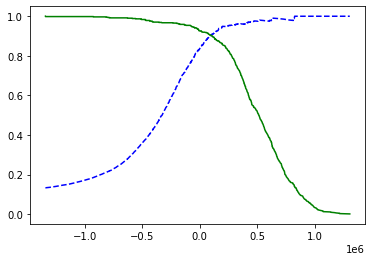

In [22]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_6, y_scores)

def plot_precision_recall_vs_threshold(precicions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [23]:
# So if we want to set out model to get 95% precision, we look at the model, 
# and see that happens at a threshold of approx 200,000.

threshold_95_precision = thresholds[np.argmax(precisions >= 0.95)]
threshold_95_precision

226977.11146997922

In [24]:
# Now, we don't use predict, we simply see if it is above the decision function threshold we now have

y_train_pred_95 = (y_scores >= threshold_95_precision)

In [25]:
print(precision_score(y_train_6, y_train_pred_95))
print(recall_score(y_train_6, y_train_pred_95))

0.9515828677839852
0.8404605263157895


Compared to earlier, precision went up, but recall went down... as expected.

### Receiver Operating Characteristic (ROC)

Recall is the True Positive Rate. When compared to the False Positive Rate, we call it the ROC curve. Think of it as "sensitivity to specificity'. 

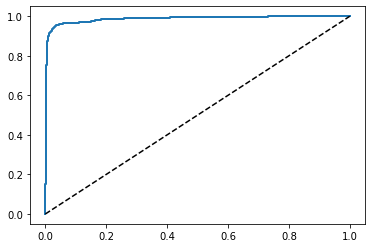

In [26]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_6, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--') # totally random
    
plot_roc_curve(fpr, tpr)
plt.show()

In [27]:
# Greater the area under the ROC, the better.

from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_6, y_scores)

0.9880408841558643

If
1. Positive cases are rare, or, care more about False Positive than False Negative - use Precision Recall Curve
2. Otherwise use ROC Curve.

### Random Forest ROC Comp

In [28]:
from sklearn.ensemble import RandomForestClassifier

forest_model = RandomForestClassifier(random_state=25)
y_prob_forest = cross_val_predict(forest_model, X_train, y_train_6, cv=3, method='predict_proba')

In [29]:
y_prob_forest

array([[0.99, 0.01],
       [1.  , 0.  ],
       [1.  , 0.  ],
       ...,
       [0.94, 0.06],
       [0.38, 0.62],
       [0.99, 0.01]])

In [30]:
y_scores_forest = y_prob_forest[:,1]
y_scores_forest

array([0.01, 0.  , 0.  , ..., 0.06, 0.62, 0.01])

In [31]:
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_6, y_scores_forest)

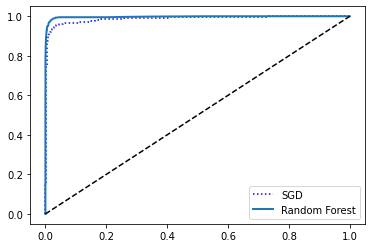

In [32]:
plt.plot(fpr,tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc='lower right')
plt.show()

The solid line for the randome forest is further from random than the SGD dotted. We can verify using AUC.

In [33]:
roc_auc_score(y_train_6, y_scores_forest)

0.9972623306457911

### Multiclass Classification

The above was trained as a binary classifier. It *is* or *is not* a 6.

We can also build multiclass, classifiers. This can be done a few ways.

#### One-Versus-The-Rest (OvR) or One-Verse-All

This is when you train a binary for each individual output. You then run all on a feature set. Which ever has the highest decision score gets the prediction.

#### One-Versus-One (OvO)

Here you place each possible classification against every other classification. So you would build a binary to distinguis 0 and 1, 0 and 2... 2 and 3, 2 and 4...etc.

Lets build a SVM [Support Vector Machine](./Classifying%20Cancer%20(Support%20Vector%20Machines).ipynb) in order to test these.

In [36]:
from sklearn.svm import SVC

svm_class = SVC()

svm_class.fit(X_train, y_train)

svm_class.predict([first_instance])

array([6], dtype=uint8)

In [38]:
# The correct prediction was from a OvO (45 different binary classifiers)

# When we pull the decision scores now, we'll get 10 not 1, one for each possible label.

instance_scores = svm_class.decision_function([first_instance])
instance_scores

array([[ 1.75048789, -0.29519743,  8.2723433 ,  1.71999931,  7.27839643,
         3.82856089,  9.3090737 ,  1.71996661,  5.08394782,  5.91739417]])

In [43]:
np.argmax(instance_scores) #the max lies at the 6th index position

6

In [44]:
svm_class.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [46]:
#svm_class.classes_[6]
svm_class.classes_[np.argmax(instance_scores)]

6

In [41]:
print(instance_scores.max()) #The max decision score
print(instance_scores[0][6]) #The 6th decision score

9.30907370094962
9.30907370094962


In [50]:
# to force a strategy, OvO or OvR, import from multiclass

from sklearn.multiclass import OneVsRestClassifier
OvR = OneVsRestClassifier(SVC())
OvR.fit(X_train, y_train)
OvR.predict([first_instance])

array([6], dtype=uint8)

In [51]:
OvR.estimators_

[SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
     max_iter=-1, probability=False, random_state=None, shrinking=True,
     tol=0.001, verbose=False),
 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
     max_iter=-1, probability=False, random_state=None, shrinking=True,
     tol=0.001, verbose=False),
 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
     max_iter=-1, probability=False, random_state=None, shrinking=True,
     tol=0.001, verbose=False),
 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
     max_iter=-1, probability=False, random_state=None, shrinking=True,
     tol=0.0

In [53]:
sgd_class = SGDClassifier()
sgd_class.fit(X_train, y_train)
sgd_class.predict([first_instance])

array([6], dtype=uint8)

In [57]:
sgd_class.decision_function([first_instance])[0]

array([-1020952.86918441,  -864804.5046685 ,  -317911.09915598,
        -624209.60618029,  -171782.55057682,  -424117.98016563,
         528882.31785303,  -435480.87277904,  -416672.28702811,
        -318001.13184096])

In [58]:
# Very confident model, all are negative except 6.
np.argmax(sgd_class.decision_function([first_instance])[0])

6

In [60]:
cross_val_score(sgd_class, X_train, y_train, cv=3, scoring='accuracy')

array([0.852 , 0.867 , 0.8515])

### Fine Tuning

Lets take the same Randome Forest from above (sgd_class), and just scale the inputs.

In [61]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [62]:
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [65]:
cross_val_score(sgd_class, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.872, 0.897, 0.891])

## Error Analysis

Finding ways to improve a model is ehanced by looking at the errors it makes.

In [66]:
y_train_pred = cross_val_predict(sgd_class, X_train_scaled, y_train, cv=3)

In [67]:
conf_matrix = confusion_matrix(y_train, y_train_pred)
conf_matrix

array([[573,   0,   1,   2,   1,  10,   3,   0,   2,   0],
       [  0, 634,   8,   2,   1,   6,   0,   1,  17,   2],
       [ 10,   9, 498,  10,   9,   4,  10,  10,  19,   2],
       [  3,   6,  22, 510,   1,  36,   1,   8,  11,  10],
       [  3,   2,   9,   0, 557,   2,   9,   8,   8,  25],
       [  5,   6,   5,  25,  14, 410,  10,   1,  25,  13],
       [  4,   4,   7,   0,   4,   7, 578,   1,   3,   0],
       [  4,   5,   8,   2,   9,   0,   1, 577,   2,  43],
       [  1,  16,  14,  16,   4,  10,   7,   3, 467,  13],
       [  6,   4,   5,   7,  15,   4,   0,  30,   9, 521]])

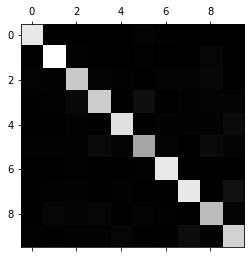

In [69]:
plt.matshow(conf_matrix, cmap=plt.cm.gray)
plt.show()

## Multilabel Classification

What if we want to label each prediction with multiple features? Maybe, is it High and is it odd?

In [71]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7) #creating a training set of T/F for if it is high
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [72]:
knn_class = KNeighborsClassifier()

In [73]:
knn_class.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [74]:
knn_class.predict([first_instance])

array([[False, False]])

Correct, 6 is neither *high* nor *odd*.

We can look at the F score for each lable, and then put them together.

In [75]:
y_train_knn_pred = cross_val_predict(knn_class, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.9500922726736858

## Multioutput Classification